## CF - Recommendation models - 

based on https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

### First code for basic Collaborative FIltering models

In [2]:
import numpy as np
import pandas as pd

In [3]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip ml-100k.zip

### Read the ratings dataset

In [4]:
!ls ml-100k

README       u.genre      u.user       u3.base      u5.base      ub.base
allbut.pl    u.info       u1.base      u3.test      u5.test      ub.test
mku.sh       u.item       u1.test      u4.base      ua.base
u.data       u.occupation u2.base      u4.test      ua.test


In [5]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('./ml-100k/u.data', sep='\t', names=names)
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
print(ratings_df.describe())
print("")
nusers = ratings_df["user_id"].nunique()
nproducts = ratings_df["item_id"].nunique()
print(str(nusers)+ " number of unique users")
print(str(nproducts)+" number of unique items")

            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08

943 number of unique users
1682 number of unique items


### create the user-item rating matrix (it is a explicit reco model)

In [7]:
ratings = np.zeros((nusers , nproducts))

In [8]:
# create a nusers X nitems matrix and fill in the ratings values
for row in ratings_df.itertuples():    
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [9]:
# Check the sparsity
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print(f'The sparsity of the ratings matrix is {sparsity}% ')


The sparsity of the ratings matrix is 6.304669364224531% 


### Take 10 random ratings from each user and create them to be the test set, for the collaborative filtering model

In [10]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
#         print(test_ratings)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]        
    return train, test

In [11]:
# it takes 10 random ratings from each user and create them to be the test set, for the collaborative filtering model
train, test = train_test_split(ratings)
print(train.shape)
print(test.shape)

(943, 1682)
(943, 1682)


### define the Similarity function - cosine distance

In [12]:
def cosine_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [13]:
user_cosine_similarity = cosine_similarity(train, kind='user')
item_cosine_similarity = cosine_similarity(train, kind='item')
print(item_cosine_similarity[:4, :4])

[[1.         0.40767266 0.34094174 0.46778331]
 [0.40767266 1.         0.27191457 0.49555453]
 [0.34094174 0.27191457 1.         0.32054643]
 [0.46778331 0.49555453 0.32054643 1.        ]]


In [14]:
print(user_cosine_similarity.shape)
print(train.shape)

(943, 943)
(943, 1682)


In [15]:
print(user_cosine_similarity.dot(ratings).shape)
print(np.array([np.abs(user_cosine_similarity).sum(axis=1)]).shape)

(943, 1682)
(1, 943)


### Generate the average rating based on most similar users and normalizing the ratings

In [16]:
def predict_ratings(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [17]:
%timeit predict_ratings(train, user_cosine_similarity, kind='user')

35.4 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Use MSE to evaluate predictions 

In [18]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [19]:
item_prediction = predict_ratings(train, item_cosine_similarity, kind='item')
user_prediction = predict_ratings(train, user_cosine_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))


User-based CF MSE: 8.397952630219274
Item-based CF MSE: 11.485512367988559


In [20]:
print(user_prediction[test.nonzero()].flatten())
print(" ")
print(test[test.nonzero()].flatten())
mean_squared_error(user_prediction[test.nonzero()].flatten(), test[test.nonzero()].flatten())

[2.01086589 0.47652166 0.8214786  ... 1.04576613 2.03603448 0.68420625]
 
[4. 4. 5. ... 5. 3. 2.]


8.397952630219274

In [ ]:
def predict_topk_similar_optimized(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_sorted_k = user_cosine_similarity[user_cosine_similarity.argsort(axis=1)[::-1][1,:k]]
        
        

In [30]:
ratings[:, 1][top_k_user1].shape

(943, 20)

In [33]:
k=20
# top_k_user1= user_cosine_similarity.argsort(axis=1)[::-1][:,:k]
# top_k_user1[1]

user_sorted_k = user_cosine_similarity[user_cosine_similarity.argsort(axis=1)[::-1][1,:k]]
user_sorted_k

array([[1.85481446e-01, 6.20825785e-02, 1.53870192e-02, ...,
        2.11265929e-12, 8.49711215e-13, 6.70815295e-13],
       [9.80558699e-02, 9.28643488e-02, 3.43708701e-02, ...,
        2.94948038e-12, 1.18628052e-12, 1.40478630e-02],
       [1.67104343e-01, 1.57370490e-02, 2.18421846e-12, ...,
        2.99896254e-12, 1.20618223e-12, 9.52235861e-13],
       ...,
       [2.20378751e-12, 7.40923707e-02, 1.85105266e-01, ...,
        9.41304158e-12, 3.78592375e-12, 2.98884552e-12],
       [8.74186347e-02, 2.06249512e-02, 1.90842214e-02, ...,
        2.62029033e-02, 5.26940168e-03, 7.79999246e-02],
       [8.57391488e-02, 1.59093789e-01, 3.27941129e-02, ...,
        7.20428422e-02, 6.03658732e-03, 1.36297888e-01]])

### Rather than taking ratings from all users , only take ratings from top K users

In [23]:
import warnings
warnings.filterwarnings("ignore")

def predict_topk_similar(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [24]:
pred = predict_topk_similar(train, user_cosine_similarity, kind='user', k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk_similar(train, item_cosine_similarity, kind='item', k=40)
print('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 6.494642640515496
Top-k Item-based CF MSE: 7.7242516219716535


### The value of K can be treated as a hyper-param and checked for better result

In [28]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_train_mse = []
item_test_mse = []

# Loop through the values of K and calcuate the train and test mse 
for k in k_array:
    user_pred = predict_topk_similar(train, user_cosine_similarity, kind="user", k=k)
    item_pred = predict_topk_similar(train, item_cosine_similarity, kind="item", k=k)
#     print(user_pred)
#     print(item_pred)
            
    user_train_mse.append(get_mse(user_pred, train))
    user_test_mse.append(get_mse(user_pred, test))
    print(user_train_mse)
    print(user_test_mse)
    
    item_train_mse.append(get_mse(item_pred, train))
    item_test_mse.append(get_mse(item_pred, test))


[1.827169932093758]
[8.518755834583349]
[1.827169932093758, 3.0431636290728177]
[8.518755834583349, 6.955173459370738]
[1.827169932093758, 3.0431636290728177, 3.684964973773002]
[8.518755834583349, 6.955173459370738, 6.575927499964256]
[1.827169932093758, 3.0431636290728177, 3.684964973773002, 4.154345444105158]
[8.518755834583349, 6.955173459370738, 6.575927499964256, 6.472602845947772]
[1.827169932093758, 3.0431636290728177, 3.684964973773002, 4.154345444105158, 4.837557209383592]
[8.518755834583349, 6.955173459370738, 6.575927499964256, 6.472602845947772, 6.5368372505406365]
[1.827169932093758, 3.0431636290728177, 3.684964973773002, 4.154345444105158, 4.837557209383592, 5.681906230720091]
[8.518755834583349, 6.955173459370738, 6.575927499964256, 6.472602845947772, 6.5368372505406365, 6.846127860015914]


In [29]:
item_train_mse

[1.6282508150538855,
 2.663883877473766,
 3.264959798694257,
 3.715643774651379,
 4.4329150022227,
 5.387449219727602]

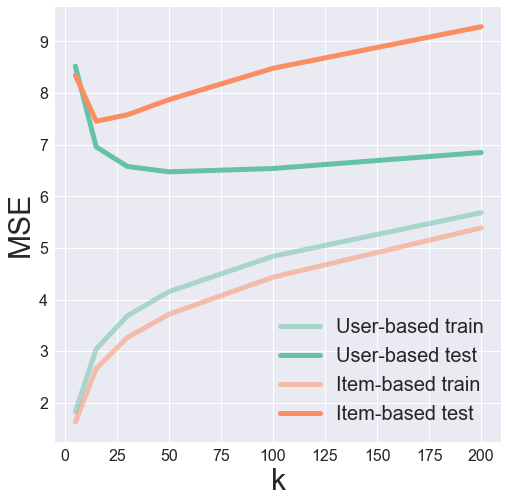

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8,8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);